In [1]:
# -----------------------------------------------------------------------------------
# 파일명       : Image_Segmentation.ipynb
# 설명         : Image Segmentation (U-Net)을 통한 소아 복부 질환 탐지       
# 작성자       : 이민하
# 작성일       : 2025-08-26
# 
# 사용 모듈    :
#
#
# -----------------------------------------------------------------------------------
# >> 주요 기능
# - 정상 1, 비정상 4가지의 상황을 Image Segmentation을 통해 구별
# - Computer Vision 분야의 U-Net 구조를 직접 구현 
#
# >> 업데이트 내역
# [2025-08-26] 데이터 확인 및 불러오기
# [2025-08-27] 데이터셋 구현
# [2025-08-28] Original U-Net 구현
# [2025-08-29] Dice Loss + Cross Entropy Loss 구현 및 학습 진행
#
# >> 성능
#
# -----------------------------------------------------------------------------------


In [2]:
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import albumentations as A

from torchmetrics.segmentation import DiceScore

from PIL import Image, ImageDraw

import cv2

import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from torchinfo import summary

from XRaySegModules import *

In [3]:
# 데이터 경로 설정
TRAIN_DATA_DIR = r"F:/Stomach_X-ray/Pediatric_Abdominal_X-ray/Training/Source_Data"
TRAIN_LABEL_DIR = r"F:/Stomach_X-ray/Pediatric_Abdominal_X-ray/Training/Labeling_Data"

VAL_DATA_DIR = r"F:/Stomach_X-ray/Pediatric_Abdominal_X-ray/Validation/Source_Data"
VAL_LABEL_DIR = r"F:/Stomach_X-ray/Pediatric_Abdominal_X-ray/Validation/Labeling_Data"

In [4]:
# 데이터 변형 및 전처리
transConvert = v2.Compose([
    v2.Resize(size=(512, 512)),
    v2.Grayscale(num_output_channels=1),
    # v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True)
])

# 데이터 셋 생성
imgDS = ImageFolder(root=TRAIN_DATA_DIR, transform=transConvert)

In [5]:
# 데이터 셋 확인
print(f"imgDS.classes       : {imgDS.classes}")
print(f"imgDS.class_to_idx  : {imgDS.class_to_idx}")
print(f"imgDS.targets       : {imgDS.targets}")


for i in range(10):
    print(f"imgDS.imgs      : {imgDS.imgs[i]}")

imgDS.classes       : ['1.Pyloric_Stenosis', '2.Pneumoperitoneum', '3.Air_Fluid_Level', '4.Constipation', '5.Normal']
imgDS.class_to_idx  : {'1.Pyloric_Stenosis': 0, '2.Pneumoperitoneum': 1, '3.Air_Fluid_Level': 2, '4.Constipation': 3, '5.Normal': 4}
imgDS.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [6]:
# 데이터 준비
folder_list = []
label_file_list = []
label_list = []

for folder in os.listdir(TRAIN_LABEL_DIR)[:5]:
    folder_list.append(os.path.join(TRAIN_LABEL_DIR, folder))

for dir in folder_list:
    for file_name in os.listdir(dir)[:500]:
        label_file_list.append(os.path.join(dir, file_name))

for file in label_file_list:
    with open(file, "r", encoding="utf-8") as f:
        label_list.append(json.load(f))

print(len(label_file_list))

2500


In [7]:
# 데이터 준비
val_folder_list = []
val_label_file_list = []
val_label_list = []

for folder in os.listdir(VAL_LABEL_DIR)[:5]:
    val_folder_list.append(os.path.join(VAL_LABEL_DIR, folder))

for dir in val_folder_list:
    for file_name in os.listdir(dir)[:100]:
        val_label_file_list.append(os.path.join(dir, file_name))

for file in val_label_file_list:
    with open(file, "r", encoding="utf-8") as f:
        val_label_list.append(json.load(f))

print(len(val_label_file_list))

500


In [8]:
replace_dict = {"Labeling_Data": "Source_Data", ".json": ".png"}

train_file_list = [reduce(lambda x, y: x.replace(*y), replace_dict.items(), file) for file in label_file_list]
val_file_list = [reduce(lambda x, y: x.replace(*y), replace_dict.items(), file) for file in val_label_file_list]


print(len(train_file_list), len(val_file_list))

2500 500


In [9]:
transform = A.Compose([ 
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0, rotate_limit=5, p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.2, p=0.5), 
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),
    A.pytorch.ToTensorV2()
    ])

c:\Users\PNC\anaconda3\envs\Doctor_310\lib\site-packages\albumentations\core\validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
BATCH_SIZE = 16

trainDS = XRayDataset(train_file_list, label_list, transform)
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)

valDS = XRayDataset(val_file_list, val_label_list, transform)
valDL = DataLoader(valDS, batch_size=BATCH_SIZE)

2500
torch.Size([1, 512, 512]) torch.Size([512, 512])
tensor([0])


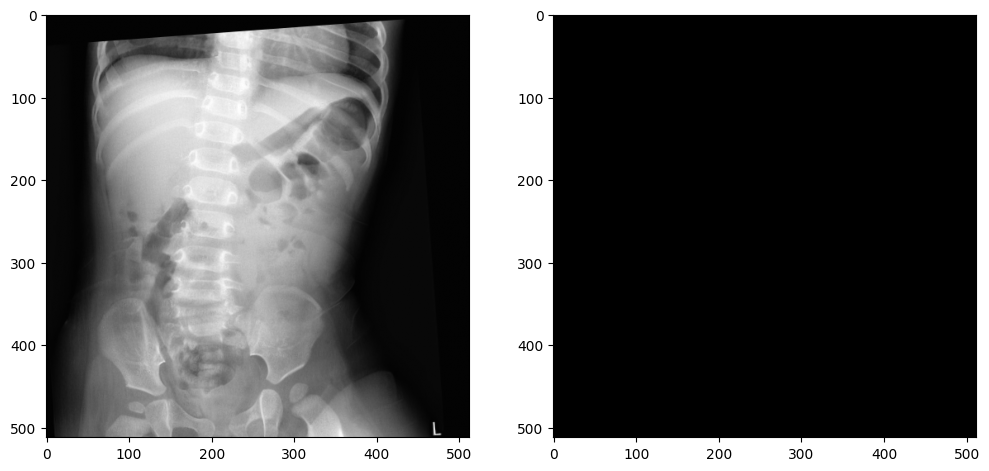

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes = axes.flatten()

i = 0

print(len(trainDS))

for img, mask in trainDS:
    i += 1
    if i == 2499:
        print(img.shape, mask.shape)
        axes[0].imshow(img.squeeze(), cmap="gray")
        axes[1].imshow(mask, cmap="gray")
        print(mask.unique())
        break


In [ ]:
EPOCH = 300
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-3

num_classes = 5

model = OriginUNet(num_classes=num_classes).to(DEVICE)

score_fn = DiceScore(num_classes=num_classes, include_background=True, average="macro", input_format="index")
loss_fn = CustomWeightedLoss(score_fn=score_fn, device=DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LR)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10)

print(summary(model))

TypeError: CustomWeightedLoss.__init__() got an unexpected keyword argument 'score_fn'

In [ ]:
import torch
import torch.nn.functional as F

B, C, H, W = 1, 3, 2, 2  # 배치=1, 클래스=3, 이미지=2x2
logits = torch.tensor([[
    [[2.0, 0.5], [0.1, 1.2]],   # class 0 채널
    [[1.0, 2.5], [0.2, 0.1]],   # class 1 채널
    [[0.5, 0.3], [3.0, 0.9]]    # class 2 채널
]])  # shape: [1, 3, 2, 2]

target = torch.Tensor([
  [[0, 1],
   [2, 1]]
]).long()  # shape [1, 2, 2], 클래스 0~2


# 1) Softmax + Argmax (클래스 인덱스 예측)
probs = F.softmax(logits, dim=1)          # [1, 3, 2, 2]
pred_classes = torch.argmax(probs, dim=1) # [1, 2, 2]

# 2) Argmax 결과를 One-hot 변환
target_onehot = F.one_hot(target, num_classes=C)
target_onehot = target_onehot.permute(0, 3, 1, 2).float()

pred_onehot = F.one_hot(pred_classes, num_classes=C)  # [1, 2, 2, 3]
pred_onehot = pred_onehot.permute(0, 3, 1, 2).float() # [1, 3, 2, 2]

print("예측 클래스 인덱스 맵:\n", pred_classes)

print("One-hot으로 변환한 결과 (target):\n", target_onehot)
print("One-hot으로 변환한 결과 (pred):\n", pred_onehot)


예측 클래스 인덱스 맵:
 tensor([[[0, 1],
         [2, 0]]])
One-hot으로 변환한 결과 (target):
 tensor([[[[1., 0.],
          [0., 0.]],

         [[0., 1.],
          [0., 1.]],

         [[0., 0.],
          [1., 0.]]]])
One-hot으로 변환한 결과 (pred):
 tensor([[[[1., 0.],
          [0., 1.]],

         [[0., 1.],
          [0., 0.]],

         [[0., 0.],
          [1., 0.]]]])
